## Overview
In this notebook, we will be attempting to find attractive areas for a new Chipotle restaurant location in Queens, NY. We will use demographic data from the US Census Bureau and venue data from Foursquare. We will explore the data using descriptive plots and choropleth maps, as well as by performing a principal components analysis. Then, we will run a cluster analysis to determine if there are groups of characteristics that different areas have in common. Finally, we will run a linear regression to predict the number of competitor restaurants in each area, and we will look for outliers that might be attractive for a new restaurant location. 

We start by importing various libraries that we'll use for working with the data, interacting with APIs, and creating maps. We'll also define the API credentials we will be using, which will be blank in the public version of this notebook.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline
matplotlib.style.use('ggplot')

#Census API key
censuskey = ''

#Foursquare API credentials
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180604'
ACCESS_TOKEN = ''

## Data
#### Census Tract Demographics
We begin by obtaining demographic data for all census tracts in Queens, NY using the US Census Bureau API for American Community Survey 5-year Data. Information on the API and dataset can be found [here](https://www.census.gov/data/developers/data-sets/acs-5year.html).

Queries are formed by requesting certain variables in a dataset for certain geographical areas. Here, we use the 2019 ACS 5-year estimates Subject and Detailed tables. We request data for all census tracts in Queens County, New York. The variable codes can be obtained by searching the list [here](https://api.census.gov/data/2019/acs/acs5/variables.html).

In [2]:
dataset = '2019/acs/acs5/subject'
dataset2 = '2019/acs/acs5'
state = '36' #Code for NY
county = '081' #Code for Queens County
varlist = 'S1901_C01_012E,S0101_C03_032E,S1501_C01_005E,S1501_C01_001E,S1501_C01_015E,S1501_C01_006E,S0101_C01_001E,S0501_C01_014E'
varnames = ['median income','median age','bachelors degree25u','pop25u','bachelors degree','pop25o','total population','percent white']
varlist2 = 'B01001A_001E'
varnames2 = ['white pop']
url = f'https://api.census.gov/data/{dataset}?get={varlist}&for=tract:*&in=state:{state}&in=county:{county}&key={censuskey}'
url2 = f'https://api.census.gov/data/{dataset2}?get={varlist2}&for=tract:*&in=state:{state}&in=county:{county}&key={censuskey}'

Now that our requests are formed, we obtain the JSON responses and put them into pandas DataFrames. We do some simple arithmetic so we can work with percentages instead of total amounts, and then we drop the unneeded columns. We also drop null values, which are represented as negative values in this dataset.

In [3]:
res1 = requests.get(url).json()
res2 = requests.get(url2).json()

df1 = pd.DataFrame(res1[1:],columns=varnames+res1[0][-3:])
df2 = pd.DataFrame(res2[1:],columns=varnames2+res2[0][-3:])

df1 = df1.astype({n:int for n in varnames[2:-1]})
df1 = df1.astype({n:float for n in varnames[:2]})
df2 = df2.astype({'white pop':int})

df1['percent white'] = df2['white pop']/df1['total population']
df1['bachelors degree'] = (df1['bachelors degree']+df1['bachelors degree25u'])/(df1['pop25u']+df1['pop25o'])
df1.drop('bachelors degree25u',axis=1,inplace=True)
df1.drop('pop25u',axis=1,inplace=True)
df1.drop('pop25o',axis=1,inplace=True)
df1.dropna(axis=0,inplace=True)
df1.sort_values(by='tract',ignore_index=True,inplace=True)
df1 = df1[(df1[['median income','median age']]>0).all(1)]

Now, lets take a look at our dataset and see if things look reasonable

In [4]:
df1.shape

(640, 8)

In [5]:
df1.head()

,median income,median age,bachelors degree,total population,percent white,state,county,tract
0,150421.0,34.8,0.782731,9505,0.607154,36,081,000100
1,70655.0,37.8,0.228443,3019,0.536270,36,081,000200
2,63462.0,36.1,0.214604,4476,0.290438,36,081,000400
3,83150.0,35.4,0.230445,4107,0.334794,36,081,000600
4,134519.0,36.0,0.710235,6336,0.605271,36,081,000700


In [6]:
df1.describe()

,median income,median age,bachelors degree,total population,percent white
count,640.000000,640.000000,640.000000,640.000000,640.000000
mean,73779.564062,38.379844,0.305302,3573.015625,0.379070
std,20449.775596,5.947566,0.141092,1939.125317,0.273437
min,19178.000000,19.100000,0.048699,697.000000,0.000000
25%,61513.750000,34.300000,0.203449,2180.250000,0.129266
50%,72449.500000,37.800000,0.272243,3144.500000,0.352535
75%,85804.500000,41.525000,0.387356,4449.000000,0.605056
max,163750.000000,81.800000,0.838701,14284.000000,0.981636


C:\Users\plj12\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


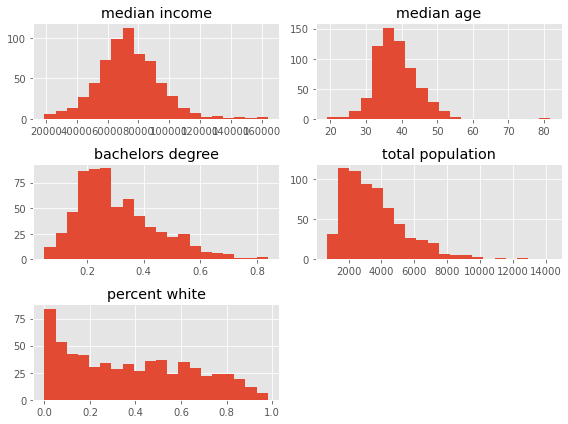

In [7]:
df1.hist(bins=20,figsize=(8,6))
plt.tight_layout()

Okay, things look pretty reasonable. However, there's one major outlier in median age, and a few outliers in some of the other features. These are probably because some of the census tracts are small and only contain a specialized type of resident. We will simply remove these outlier tracts and consider tracts which are representative of the general population.

In [8]:
df1 = df1[df1['median age']<60]
df1.shape

(639, 8)

#### Geospatial Data
Now, we will obtain geospatial data from the US Census Bureau's [TIGERweb GeoServices REST API](https://www.census.gov/data/developers/data-sets/TIGERweb-map-service.html). The TIGERweb service is based on the [ArcGIS REST API](https://developers.arcgis.com/rest/) standard. We are specifically interested in the Tracts_Blocks MapServer service for ACS 2019, located at https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer/7

From this endpoint, we will obtain coordinates, geometries, and land area for each census tract. We will use the coordinates in our later Foursquare searches. The geometries will be used to draw maps with Plotly. And the land area will be used to calculate population density.

One cool thing about this API is that we can use SQL-like syntax in our query. Here, we'll use that to limit our search to the census tracts in Queens, NY. We'll request all fields be returned, and we specify the format as geoJSON so we can feed it directly to Folium.

Finally, we will break up our request so they are short enough to be passed as a simple GET query. 

In [9]:
tracturl = 'https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer/7'
geojson = None
for tracts in np.array_split(df1['tract'].values,7):
    tractstr = ','.join(tracts)
    tigerget = requests.get(f'{tracturl}/query?where=STATE=36 and COUNTY=081 and TRACT in ({tractstr})&outFields=*&f=geojson')
    if not geojson:
        geojson = tigerget.json()
    else:
        geojson['features'] = geojson['features']+tigerget.json()['features']

We'll pull out the coordinates and area for each tract, and add them on to our original DataFrame

In [10]:
rows = []
for t in geojson['features']:
    props = t['properties']
    rows.append({'tract':props['TRACT'],'Area':float(props['AREALAND']),
                 'Lat':float(props['CENTLAT']),'Lon':float(props['CENTLON'])})
df_geo = pd.DataFrame(rows).sort_values(by='tract',ignore_index=True)

df1 = df1.merge(df_geo,on='tract')
df1['pop density'] = (df1['total population']/df1['Area'])/(3.9e-7)

In [11]:
df1.describe()

,median income,median age,bachelors degree,total population,percent white,Area,Lat,Lon,pop density
count,639.000000,639.000000,639.000000,639.000000,639.000000,6.390000e+02,639.000000,639.000000,639.000000
mean,73808.463224,38.311894,0.304937,3575.854460,0.378136,3.505166e+05,40.719814,-73.830888,36465.491870
std,20452.712685,5.698186,0.140899,1939.312997,0.272627,3.433517e+05,0.041045,0.058514,25599.189211
min,19178.000000,19.100000,0.048699,697.000000,0.000000,6.834800e+04,40.558512,-73.951409,1123.419458
25%,61518.000000,34.300000,0.203416,2182.000000,0.128853,1.711170e+05,40.694453,-73.878144,19323.641837
50%,72453.000000,37.800000,0.272231,3146.000000,0.351403,2.195370e+05,40.722480,-73.828885,28968.912180
75%,85814.000000,41.500000,0.386212,4451.000000,0.604898,4.136025e+05,40.751871,-73.784574,44589.594668
max,163750.000000,56.000000,0.838701,14284.000000,0.981636,4.374026e+06,40.798995,-73.704609,247073.227011


Now, we will take a quick break and create some maps with our demographic data. We will create choropleth maps using Plotly's Choropleth Mapbox plot type. We construct our data and layout attributes manually so we can include multiple maps in one figure. Then, we save the figure as a static image so it can be displayed in the notebook on GitHub.

In [12]:
data = []
data.append(dict(type='choroplethmapbox',geojson=geojson, locations=df1.tract, z=df1['median income'],
                                     featureidkey='properties.TRACT',name='median income',
                                    colorscale="Viridis", zmin=0, zmax=120000,
                                    marker_opacity=0.75, marker_line_width=0,
                colorbar=dict(title='median income',thickness=10,len=.5,x=-0.10,y=.25))
           )
data.append(dict(type='choroplethmapbox',geojson=geojson, locations=df1.tract, z=df1['percent white'],
                                     featureidkey='properties.TRACT',subplot='mapbox2',name='percent white',
                                    colorscale="Viridis", zmin=0, zmax=1,
                                    marker_opacity=0.75, marker_line_width=0,
                colorbar=dict(title='percent white',thickness=10,len=.5,x=1.0,y=.25))
           )
data.append(dict(type='choroplethmapbox',geojson=geojson, locations=df1.tract, z=df1['bachelors degree'],
                                     featureidkey='properties.TRACT',subplot='mapbox3',name='bachelors degree',
                                    colorscale="Viridis", zmin=0, zmax=.75,
                                    marker_opacity=0.75, marker_line_width=0,
                colorbar=dict(title='bachelors degree',thickness=10,len=.5,x=-0.10,y=.85))
           )
data.append(dict(type='choroplethmapbox',geojson=geojson, locations=df1.tract, z=df1['pop density'],
                                     featureidkey='properties.TRACT',subplot='mapbox4',name='pop density',
                                    colorscale="Viridis", zmin=0, zmax=200000,
                                    marker_opacity=0.75, marker_line_width=0,
                colorbar=dict(title='pop density',thickness=10,len=.5,x=1.0,y=.85))
           )
layout = {}
layout['mapbox'] = {'center': {'lat': 40.719813583724594, 'lon': -73.83088848794984},
               'domain': {'x': [0.0, .475], 'y': [0.0, .475]},
               'style': 'carto-positron',
               'zoom': 9}
layout['mapbox2'] = {'center': {'lat': 40.719813583724594, 'lon': -73.83088848794984},
               'domain': {'x': [0.525, 1.0], 'y': [0.0, .475]},
               'style': 'carto-positron',
               'zoom': 9}
layout['mapbox3'] = {'center': {'lat': 40.719813583724594, 'lon': -73.83088848794984},
               'domain': {'x': [0.0, .475], 'y': [0.525, 1.0]},
               'style': 'carto-positron',
               'zoom': 9}
layout['mapbox4'] = {'center': {'lat': 40.719813583724594, 'lon': -73.83088848794984},
               'domain': {'x': [0.525, 1.0], 'y': [0.525, 1.0]},
               'style': 'carto-positron',
               'zoom': 9}
layout['margin'] = {'l':50,'r':150,'t':10,'b':10}

fig = go.Figure(data=data,layout=layout)
fig.write_image('fig1.png',engine='kaleido')
#Interactive figure
#fig.show()

![fig1](fig1.png)

Cool! We can already see some interesting geographic patterns in the data. There's a large cluster of non-white population in the southeast, and smaller clusters in the center. There's some clusters of high-percentage white population in the north and southwest, and the rest fall into the range between 20%-70%, as seen in the histogram previously. Interestingly, income seems to vary on smaller scales than education or ethnicity. Education and income seem correlated, and both are maybe weakly correlated with ethnicity. We will return to this topic when we do our exploratory analysis.

Finally, the population density data is obscured by one large outlier, which we will now remove.

In [13]:
df1 = df1[df1['pop density']<200000]

#### Foursquare Venue Data
Now, we will move on to obtaining the venue data using the Foursquare Places API. We will proceed in two parts. First, we will try to determine what venue categories are associated with competitors of Chipotle. To do this, we will obtain a list of Chipotle locations in NYC using the venues/search endpoint. Then, for each Chipotle we return all the user-created lists that they are on using the venues/listed endpoint. Finally, we count up all the venue categories that appear on those lists using the list endpoint. Hopefully the frequently occurring venue categories represent venues that compete with Chipotle or are popular with a similar demographic. We will also record the category IDs to use in our later searches.

We'll first define some functions to help process the Chipotle locations and lists, then we'll run everything in a big for loop. This process will take a few minutes because of all the nested loops, but this is fine for our purposes.

In [2]:
def get_lists(chipid):
    chipurl = f'https://api.foursquare.com/v2/venues/{chipid}/listed?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'
    res = requests.get(chipurl).json()
    return res['response']['lists']['groups'][0]['items']

In [3]:
def count_cats(catcount,catids,cats):
    for c in cats:
        catid = c['category']['id']
        name = c['category']['name']
        catids[name] = catid
        try:
            catcount[name] = catcount[name]+int(c['count'])
        except KeyError:
            catcount[name] = int(c['count'])
    return catcount,catids


In [4]:
LIMIT = 100
#furl = f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&near=Queens,NY&v={VERSION}&limit={LIMIT}&query=Chipotle%20Mexican%20Grill'
furl = f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&near=Queens,NY&v={VERSION}&radius=12000&limit={LIMIT}&query=Chipotle%20Mexican%20Grill'
res = requests.get(furl).json()
chips = res['response']['venues']
chips = [c for c in chips if 'Chipotle' in c['name']]
    
catcount = {}
catids = {}
for c in chips[:]:
    lists = get_lists(c['id'])
    for l in lists:
        listid = l['id']
        listurl = f'https://api.foursquare.com/v2/lists/{listid}/?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'
        res = requests.get(listurl).json()
        catcount,catids = count_cats(catcount,catids,res['response']['list']['categories']['items'])
cframe = pd.DataFrame(catcount.items(),columns=['Categories','Count']) 
idframe = pd.DataFrame(catids.items(),columns=['Categories','ID'])
df_cats = (cframe.merge(idframe,on='Categories',how='inner')).sort_values(by='Count',ascending=False,ignore_index=True)

In [5]:
clats = [c['location']['lat'] for c in chips if 'Chipotle' in c['name']]
clons = [c['location']['lng'] for c in chips if 'Chipotle' in c['name']]

In [18]:
cfig = px.scatter_mapbox(lat=clats,lon=clons,center={"lat": df1['Lat'].mean(), "lon": df1['Lon'].mean()},
                           mapbox_style="carto-positron", zoom=9.5)
cfig.write_image('cfig.png',engine='kaleido')
#Interactive figure
#cfig.show()

In [10]:
df_cats.head(10).to_html('table1.html',index=False,columns=['Categories','Count'])

In [19]:
df_cats.shape

(202, 3)

In [6]:
df_cats.head(10).to_latex('table1.txt',columns=['Categories','Count'],index=False,position='h',label='tab1')
df_cats.head(10)

,Categories,Count,ID
0,Mexican Restaurant,706,4bf58dd8d48988d1c1941735
1,Asian Restaurant,319,4bf58dd8d48988d142941735
2,Bar,122,4bf58dd8d48988d116941735
3,Pizza Place,100,4bf58dd8d48988d1ca941735
4,American Restaurant,96,4bf58dd8d48988d14e941735
5,Italian Restaurant,94,4bf58dd8d48988d110941735
6,Food & Drink Shop,92,4bf58dd8d48988d1f9941735
7,Vegetarian / Vegan Restaurant,81,4bf58dd8d48988d1d3941735
8,Seafood Restaurant,79,4bf58dd8d48988d1ce941735
9,Dessert Shop,73,4bf58dd8d48988d1d0941735


And there you have it! The top 10 most frequently occurring venue categories in lists with Chipotle. It's not surprising that "Mexican Restauraunt" shows up as the top category, but some of the other categories, like "Juice Bar," might not be expected to be in our list of "competitors." It makes more sense if we remember that we are looking at similarities in customer-base rather than in services provided.

Now, on to the second task. We will obtain a "density" of competitor venues for each census tract. To do this, we will put the latitude and longitude we obtained for each tract into a Foursquare search query, which we will filter by the category types we just obtained and limit to within a 500m radius. Again, this might take a few minutes and could probably be done more efficiently if we saved a list of competitors and filtered by distance ourselves, but it's simpler and practical to just leverage the Foursquare API in this case.

In [21]:
catlist = df_cats.head(5)['ID'].values
radius = 500
def get_venue_count(lat,lon):
    furl = f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={lat},{lon}&v={VERSION}&limit={LIMIT}&radius={radius}&categoryId={",".join(catlist)}'
    res = requests.get(furl).json()
    return len(res['response']['venues'])

In [22]:
counts = [get_venue_count(lat,lon) for lat,lon in zip(df1['Lat'],df1['Lon'])]

In [23]:
df1['venue density']=(counts/df1['total population'])

array([[<AxesSubplot:title={'center':'venue density'}>]], dtype=object)

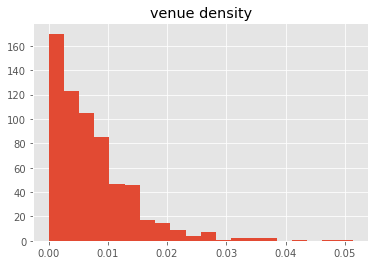

In [24]:
df1.hist(column='venue density',bins=20)

Okay! We can see that most tracts have very low venue densities, but there's a long tail to higher densities. This might be because many tracts are mainly residential areas with few businesses. Before we move on to our next section, let's see how this venue data looks on the map.

In [25]:
data = [(dict(type='choroplethmapbox',geojson=geojson, locations=df1.tract, z=df1['venue density'],
                                     featureidkey='properties.TRACT',subplot='mapbox',name='venue density',
                                    colorscale="Viridis", zmin=0, zmax=.05,
                                    marker_opacity=0.75, marker_line_width=0,
                colorbar=dict(title='venue density',thickness=10,len=.5,x=1.0,y=.85))
           )]
layout = {}
layout['mapbox'] = {'center': {'lat': 40.719813583724594, 'lon': -73.83088848794984},
               'domain': {'x': [0.0,1.0], 'y': [0.0, 1.0]},
               'style': 'carto-positron',
               'zoom': 9.8}
layout['margin'] = {'l':50,'r':350,'t':10,'b':100}
fig2 = go.Figure(data=data,layout=layout)
fig2.write_image('fig2.png',engine='kaleido')
#Interactive figure
#fig2.show()

![fig2](fig2.png)

Cool! As expected from the histogram, we see there are many tracts with very low density. We also see that the higher density tracts are mainly located in the central and western parts of Queens.

Now, we'll move on to some exploratory analysis.

## Exploratory Analysis
Our exploratory analysis will mainly consist of looking at the correlations between our chosen features. We will then run a principal components analysis to see if it would be beneficial to reduce the dimensionality of our dataset.

We'll start by looking at the scatter plot matrix for our features.

C:\Users\plj12\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



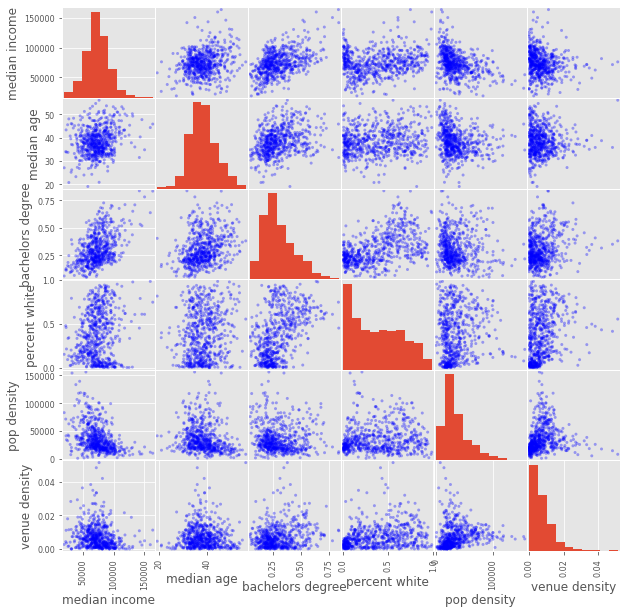

In [26]:
df_feats = df1[['median income','median age','bachelors degree','percent white','pop density','venue density']]
scats = pd.plotting.scatter_matrix(df_feats,color='blue',figsize=(10,10),alpha=.35)

Okay, that's a lot of scatter plots. Here's a few observations:
- The only feature that appears correlated with venue density is population density
- Education is correlated with age, income, and ethnicity
- However, age, income, and ethnicity do NOT seem correlated with each other

Now, let's compute the correlation matrix and see if our observations check out.

In [27]:
corr = df_feats.corr()

<AxesSubplot:>

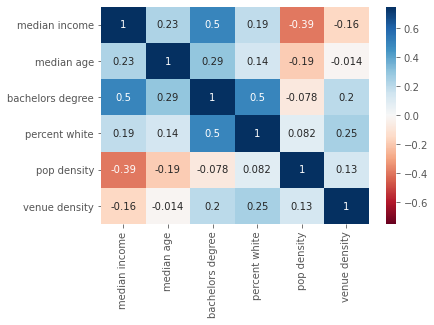

In [28]:
sns.heatmap(corr,center=0,cmap='RdBu',vmin=-.75,vmax=.75,annot=True)

Interesting! It appears we missed some relationships, probably because it's hard to make out trends on a scatter plot when points are clustered together. Notably:
- Venue density has moderate correlations with all variables except median age
- Income has a strong negative correlation with population density
- Population density has moderate negative correlations with age and education

#### Principal Components Analysis
Next, we'll run our PCA to see if there are any redundant features we should get rid of. We will sstandardize our features and compute the covariance matrix with pandas, and then we will compute the eigenvalues and eigenvectors of the covariance matrix using numpy.

In [29]:
df_dens = df_feats['venue density']
df_feats = df_feats.drop(columns='venue density')

In [30]:
df_std = (df_feats-df_feats.mean())/df_feats.std()

cov = df_std.cov().values

In [31]:
evals,evecs = np.linalg.eig(cov)
inds = np.argsort(evals)[::-1]
evals = evals[inds]
evecs = evecs[inds]

In [32]:
evals/evals.sum()

array([0.40898304, 0.24436218, 0.16395576, 0.11156185, 0.07113718])

In [33]:
evecs

array([[ 0.53532267,  0.26306208, -0.56255338,  0.36049925,  0.44474933],
       [ 0.38403497,  0.13682441, -0.12988806, -0.90349673,  0.02487915],
       [ 0.39688718, -0.58253088, -0.31845088,  0.10906892, -0.62436476],
       [-0.28445636, -0.70196463, -0.25658064, -0.17450799,  0.57449419],
       [ 0.57228658, -0.28280887,  0.70669526,  0.10669996,  0.28583936]])

We see that the smallest principal component explains 7% of the total variance. We also see that larger principal component vectors draw information from all the original features. Since we did not find any redundant variables, and the variance is fairly well spread in all directions, we will move on with our analysis using our original features.

#### Clustering
Finally, we will run a hierarchical clustering and a k-means clustering to determine if there is a natural grouping we should consider when doing our analysis. Our cluster analysis will consist of 
1. Running an agglomerative hierarchical clustering and estimate an optimal n-clusters from the dendrogram.
2. Running k-means clustering for multiple k and determining if there is an "elbow" indicating diminishing returns with respect to the cluster variance.
3. Plotting our chosen clusters on our map.

In [34]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans, AgglomerativeClustering

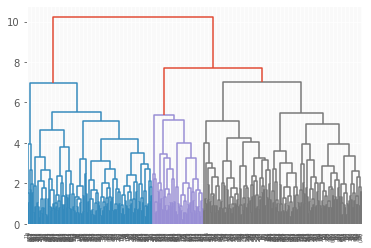

In [35]:
link = linkage(df_std,method='complete')
dn = dendrogram(link,p=10,truncate_mode='level')

By eye, it looks like n=5 might be a good clustering to try. Let's run the sci-kit agglomeration and plot it on the map.

In [36]:
ag = AgglomerativeClustering(n_clusters=5,distance_threshold=None,linkage='complete').fit(df_std)
klabels = df1[['tract']].copy()
klabels['aglabel'] = ag.labels_.astype(str)

In [37]:
fig3 = px.choropleth_mapbox(klabels,geojson=geojson,color='aglabel',
                    locations="tract", featureidkey="properties.TRACT",
                           center={"lat": df1['Lat'].mean(), "lon": df1['Lon'].mean()},
                           mapbox_style="carto-positron", zoom=9.5)
#Interactive figure
#fig3.show()
fig3.write_image('fig3.png',engine='kaleido')

![fig3](fig3.png)

Okay! There's definitely some geographical trends to these clusters, but they are quite intermingled throughout the county.

Now, we'll look at k-means clustering.

C:\Users\plj12\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



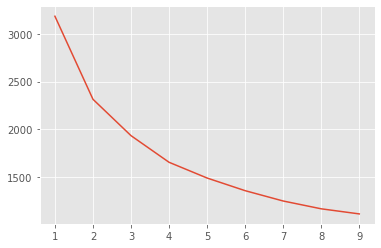

In [38]:
elbow = [(KMeans(n_clusters=i,random_state=0).fit(df_std)).inertia_ for i in range(1,10)]
plt.plot(range(1,10),elbow)

There is not an obvious "elbow" here, but k=4 looks like a decent choice.

In [39]:
km = KMeans(n_clusters=4,random_state=0).fit(df_std)
klabels['klabel'] = km.labels_.astype(str)

In [40]:
fig4 = px.choropleth_mapbox(klabels,geojson=geojson,color='klabel',
                    locations="tract", featureidkey="properties.TRACT",
                           center={"lat": df1['Lat'].mean(), "lon": df1['Lon'].mean()},
                           mapbox_style="carto-positron", zoom=9.5)
#Interactive figure
#fig4.show()
fig4.write_image('fig4.png',engine='kaleido')

![fig4](fig4.png)

Cool! The patterns here are similar to those in the agglomerative clustering, but there's more distinct geographical separation here.

## Further Analysis
Finally, we will begin our analysis of the data in order to find the best location for a new Chipotle location. First, we will look at how the venue density varies across our different clusters. We will see if our chosen venue categories are more popular in certain clusters, and then we will look for outliers within the clusters. The outliers will be places where the venue density is significantly lower then the average density of the cluster. This will hopefully point out places that could support a higher number of venues than are currently there, giving a good chance of success for a new restaurant location.

After that, we will run a linear regression over all census tracts to predict venue density based on the demographic data. Again, we will look for outliers with large residuals that might signify area that could support a new restaurant.

#### Cluster Deviations
We'll first add our k-means labels to our DataFrame, and then use pandas "group-by" functionality to compute statistics for each cluster.

In [41]:
df1['klabel'] = klabels['klabel']

In [42]:
grouped = df1.groupby(by='klabel')
grouped.mean().to_latex('table2.txt',float_format="%.3g",
                        columns=['median income','median age','bachelors degree',
                                             'percent white','pop density','venue density'],position='h',label='table:2')
grouped.mean()

,median income,median age,bachelors degree,total population,percent white,Area,Lat,Lon,pop density,venue density
klabel,,,,,,,,,,
0,50177.736111,36.327778,0.188214,5431.944444,0.316762,180755.375000,40.743190,-73.865019,80861.223050,0.007603
1,70667.000000,36.720557,0.226309,3289.979094,0.171093,372022.954704,40.704087,-73.804459,27556.356663,0.005991
2,95820.210084,45.400840,0.441226,3351.991597,0.529377,572422.882353,40.728345,-73.804008,18662.344773,0.005850
3,73861.800000,36.813125,0.397439,3352.975000,0.665153,224553.443750,40.731056,-73.882734,44392.966428,0.010868


<AxesSubplot:>

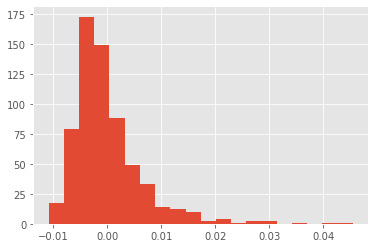

In [43]:
res = grouped['venue density'].transform(lambda x: x-x.mean())
res.hist(bins=20)

We see a sharp cutoff in negative deviations, and a long tail for positive. Now, we'll isolate and plot the negative deviations on the map.

In [44]:
df1['cluster deviation'] = -(res*(res<-.003))

fig5 = px.choropleth_mapbox(df1,geojson=geojson,color='cluster deviation',
                    locations="tract", featureidkey="properties.TRACT",
                           center={"lat": df1['Lat'].mean(), "lon": df1['Lon'].mean()},
                           mapbox_style="carto-positron", zoom=9.8)
#Interactive figure
#fig5.show()
fig5.write_image('fig5.png',engine='kaleido')

![fig5](fig5.png)

Alright, we can see some candidate locations on this map. The largest deviation occurs in the center of the map, next to the southeast end of Flushing Meadows Park.  A band of deviation extends east from this point. There's a similar, but less intense band running along the northern border of the borough. The rest of the large deviation tracts are more scattered, with the most notable occurring in the western and northwestern sections.

#### Linear Regression
Next, we'll create a linear regression model to predict venue density from demographic data. Since our dataset is relatively small, we can choose our hyperparameters by running a grid search with 10-fold cross-validation. The hyperparameters we'll consider for our linear model are the ridge regression regularization parameter and the polynomial degree.

In [45]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures

In [46]:
X = df_std.values
Y = df1['venue density']
Y = ((Y-Y.mean())/Y.std()).values

In [47]:
nfold = 10
cv = KFold(n_splits=nfold,shuffle=True,random_state=1)
alphas = [.1,1,10,100,1000,10000]
degrees = range(1,7)
cvtestscore = np.zeros((len(degrees),len(alphas),nfold))
for j,alpha in enumerate(alphas):
    for i in degrees:
        p = PolynomialFeatures(degree=i)
        Xp = p.fit_transform(X)
        rm = Ridge(alpha=alpha)
        cvtestscore[j,i-1] = cross_val_score(rm,Xp,Y,cv=cv)


Text(0.5, 1.0, 'Std(R^2)')

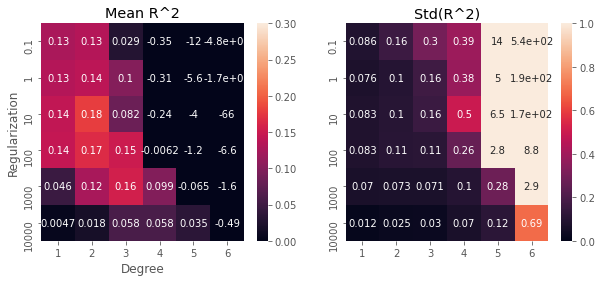

In [48]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
sns.heatmap(cvtestscore.mean(axis=-1),vmin=0,vmax=.3,xticklabels=degrees,
            yticklabels=list(map(str,alphas)),ax=ax1,annot=True)
sns.heatmap(np.std(cvtestscore,axis=-1),vmin=0,vmax=1.0,xticklabels=degrees,
            yticklabels=list(map(str,alphas)),ax=ax2,annot=True)

ax1.set_ylabel('Regularization')
ax1.set_xlabel('Degree')
ax1.set_title('Mean R^2')
ax2.set_title('Std(R^2)')

Okay. None of the models fit our dataset particularly well, with a max mean $R^2$ of 0.18. The best combination of high mean $R^2$ and relatively low standard deviation appears to be the model with polynomial degree 2 and regularization parameter 10. We will now train that model on the entire dataset and then pick out the census tracts with large negative residuals.

In [54]:
i = 2
alpha = 10.0
p = PolynomialFeatures(degree=i)
Xp = p.fit_transform(X)
rm = Ridge(alpha=alpha).fit(Xp,Y)
rm.score(Xp,Y)

0.22031746348799397

In [55]:
res = Y-rm.predict(Xp)
df1['residual'] = res

array([[<AxesSubplot:title={'center':'residual'}>]], dtype=object)

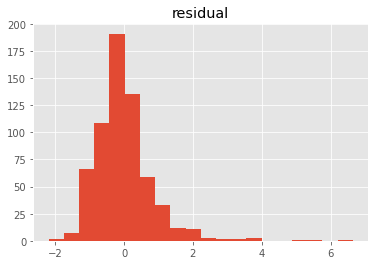

In [56]:
df1.hist(column='residual',bins=20)

Similarly to what we did with cluster deviations, we'll isolate and plot the large negative residual values on the map. 

In [57]:
df1['residual'] = -res*(res<-0.5)
fig6 = px.choropleth_mapbox(df1,geojson=geojson,color='residual',
                    locations="tract", featureidkey="properties.TRACT",
                           center={"lat": df1['Lat'].mean(), "lon": df1['Lon'].mean()},
                           mapbox_style="carto-positron", zoom=9.8)
#Interactive figure
#fig6.show()
fig6.write_image('fig6.png',engine='kaleido')

![fig6](fig6.png)

We see some similar patterns in this map as the previous one, with notable bands running east from the center. In this case the cutoff seems sharper and there are fewer scattered tracts that appear.

Finally, we'll plot the existing Chipotle locations on our two maps to see if our candidate areas in conflict with any.

In [58]:
data = []
data.append(dict(type='choroplethmapbox',geojson=geojson, locations=df1.tract, z=df1['residual'],
                                     featureidkey='properties.TRACT',name='residual',
                                     zmin=0, zmax=1.5,
                                    marker_opacity=1.0, marker_line_width=.5,
                colorbar=dict(title='residual',thickness=15,len=1,x=-0.10,y=0.5))
           )
data.append(dict(type='choroplethmapbox',geojson=geojson, locations=df1.tract, z=df1['cluster deviation'],
                                     featureidkey='properties.TRACT',subplot='mapbox2',name='cluster deviation',
                                    zmin=0, zmax=.008,
                                    marker_opacity=1.0, marker_line_width=.5,
                 colorbar=dict(title='cluster deviation',thickness=15,len=1,x=1.0,y=0.5)
                )
           )
data.append(dict(type='scattermapbox',lat=clats,lon=clons,subplot='mapbox',marker=dict(color='lightseagreen',size=8)))
data.append(dict(type='scattermapbox',lat=clats,lon=clons,subplot='mapbox2',marker=dict(color='lightseagreen',size=8)))

layout = {}
layout['mapbox'] = {'center': {'lat': 40.719813583724594, 'lon': -73.83088848794984},
               'domain': {'x': [0.0, .475], 'y': [0.0, 1.0]},
               'style': 'carto-positron',
               'zoom': 9.5}
layout['mapbox2'] = {'center': {'lat': 40.719813583724594, 'lon': -73.83088848794984},
               'domain': {'x': [0.525, 1.0], 'y': [0.0, 1.0]},
               'style': 'carto-positron',
               'zoom': 9.5}

layout['margin'] = {'l':5,'r':5,'t':50,'b':50}
layout['width'] = 800
layout['height'] = 400
layout['showlegend'] = False

fig7 = go.Figure(data=data,layout=layout)
fig7.write_image('fig7.png',engine='kaleido')
#Interactive figure
#fig7.show()

![fig7](fig7.png)

According to our Foursquare data, there are no existing Chipotle locations in the northeast quadrant of the map. Thus, the two bands in that quadrant we identified earlier seem like excellent candidates for a new location.